In [1]:
import numpy as np
import networkx as nx
from ete3 import Tree
from scipy.sparse import csgraph, csr_matrix
from scipy.sparse.linalg import spsolve
from scipy.spatial.distance import pdist, squareform
import pandas as pd
import torch
from scripts.aux_msa_functions import *
from Bio import Phylo
import esm
import os
from Bio import Phylo, AlignIO
from typing import Sequence, TypeVar, Callable, Generator, Optional
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor

TensorLike = TypeVar("TensorLike", np.ndarray, torch.Tensor)

def newick_to_graph(newick_str):
    
    t = Tree(newick_str, format=1)
    R = t.get_midpoint_outgroup()
    t.set_outgroup(R)
    G = nx.Graph()
    counter = [0]
    node_taxa_mapping = {}
    taxa_node_mapping = {}
        
    for node in t.traverse("preorder"):

        if node.is_leaf():
            node_taxa_mapping[counter[0]] = node.name
            taxa_node_mapping[node.name] = counter[0]

        node.name = counter[0]
        counter[0] += 1

        if not node.is_root():
            G.add_edge(node.up.name, node.name)

    return G, t, node_taxa_mapping, taxa_node_mapping


def reorder_seqs(tree_root, all_nat_seqs_dict):

    output = []
    
    def reorder_seqs_recur(tree_root, all_nat_seqs_dict):
    
        b = tree_root.clades
        
        if len(b)>0:
            for clade in b:
               reorder_seqs_recur(clade, all_nat_seqs_dict) 
        else:
            output.append((tree_root.name,all_nat_seqs_dict[tree_root.name]))

    reorder_seqs_recur(tree_root, all_nat_seqs_dict)

    return output






### Dirichlet Embedding Function

In [2]:
def node_embedding(tree, rooted = False, leaf_embeddings = None):

    ntips = len(tree.get_leaves()) 

    if leaf_embeddings == None:   
        leaf_embeddings = torch.eye(ntips)
        
    counter = [0]

    if rooted:
        total_nodes = 2 * ntips - 1
    else:
        total_nodes = 2 * ntips - 2

    for node in tree.traverse('postorder'):
        if node.is_leaf():
            node.c = 0
            node.d = leaf_embeddings[counter[0]]
            counter[0] += 1
        else:
            child_c, child_d = 0., 0.
            for child in node.children:
                child_c += child.c
                child_d += child.d
            if node.is_root() and rooted:
                node.c = 1./(2. - child_c)
                node.d = node.c * child_d
            else:
                node.c = 1./(3. - child_c)
                node.d = node.c * child_d
        
    node_features, edge_index, leaf_indices = [], [], []    

    for node in tree.traverse('preorder'):
        neigh_idx_list = []
        if not node.is_root():
            node.d = node.c * node.up.d + node.d
            neigh_idx_list.append(node.up.name)
            
            if not node.is_leaf():
                neigh_idx_list.extend([child.name for child in node.children])
            else:
                neigh_idx_list.extend([-1, -1])              
        else:
            if rooted:
                neigh_idx_list.extend([-1] + [child.name for child in node.children])
            else:
                neigh_idx_list.extend([child.name for child in node.children])
              
        edge_index.append(neigh_idx_list)                
        node_features.append(node.d)

        if node.is_leaf():
            leaf_indices.append(node.name)

    edge_index = torch.LongTensor(edge_index)
    
    return torch.stack(node_features), edge_index, leaf_indices

### Inverse Dirichlet Function

In [3]:
def tree_from_dirichlet_alt(embeddings, node_order,n_leaves):

    parent_children = {}
    child_parent = {}

    leaf_nodes = set(range(n_leaves))
    total_nodes = embeddings.shape[0]
    two_child_nodes = set()

    embeddings_zero = embeddings.clone()
    embeddings_zero[embeddings_zero == 1] = 0

    max_coeffs = embeddings_zero.argmax(axis = 0)
    next_int_nodes = []

    for i, coeff in enumerate(max_coeffs.tolist()):

        if coeff in list(parent_children.keys()):
            parent_children[coeff].append(i)
            two_child_nodes.add(coeff)
        else:
            parent_children[coeff] = [i]

        child_parent[i] = coeff

    internal_nodes = set(range(total_nodes)) - set(two_child_nodes) - set(leaf_nodes)

    while len(internal_nodes) > 0:

        unprocessed_nodes = list(set(parent_children.keys()) - set(child_parent.keys()))

        for key in unprocessed_nodes:

            # if key in list(child_parent.keys()):
            #     continue

            if len(internal_nodes) == 0:
                break

            if len(parent_children[key]) == 2:

                child_1 = parent_children[key][0]
                child_2 = parent_children[key][1]

                new_parent_embedding = 3 * embeddings[key] - embeddings[child_1] - embeddings[child_2]
                internal_nodes = list(internal_nodes)

                diffs = (embeddings[internal_nodes,:] - new_parent_embedding).abs().sum(dim = 1)
                
                next_int_node = internal_nodes[diffs.argmin()]
                next_int_nodes.append(next_int_node)

                internal_nodes = set(internal_nodes)

                if next_int_node not in list(parent_children.keys()):
                    parent_children[next_int_node] = [key]
                else:
                    parent_children[next_int_node].append(key)
                    internal_nodes.remove(next_int_node)
                
                # assert key not in list(child_parent.keys())
                child_parent[key] = next_int_node
    
    orphans = list(set(parent_children.keys()) - set(child_parent))

    if len(orphans) == 2:
        child_parent[orphans[0]] = orphans[1]

    inferred_edges = []

    for k, v in zip(child_parent.keys(), child_parent.values()):

        u = node_order[k]
        v = node_order[v]

        inferred_edges.append((min(u,v), max(u,v)))

    return parent_children, child_parent, inferred_edges


In [ ]:
parent_children, children_parent, inferred_edges = tree_from_dirichlet_alt(X_train[0], node_order, 207)

### Learning Taxa-OHE mapping

In [12]:
import torch.nn as nn

class OHEPredictor(nn.Module):

    def __init__(self, input_size, hid_dim, output_dim):

        super().__init__()

        self.input_layer = nn.Linear(input_size, hid_dim)
        self.hidden_layer = nn.Linear(hid_dim, hid_dim)
        self.output_layer = nn.Linear(hid_dim, output_dim)
        self.relu =  nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):

        x = self.input_layer(x)
        x = self.sigmoid(x)
        x = self.hidden_layer(x)
        x = self.sigmoid(x)
        x = self.output_layer(x)

        return x


In [13]:
def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape)
    return -torch.log(-torch.log(U + eps) + eps)

def gumbel_sinkhorn(logits, n_iters=100, tau=1.0):
    gumbel_noise = sample_gumbel(logits.shape).to(logits.device)
    noisy_logits = (logits + gumbel_noise) / tau
    return sinkhorn(noisy_logits, n_iters)

def sinkhorn(logits, n_iters=100, eps=1e-8):
    logits = torch.exp(logits)
    for _ in range(n_iters):
        logits = logits / (logits.sum(dim=1, keepdim=True) + eps)  # row norm
        logits = logits / (logits.sum(dim=0, keepdim=True) + eps)  # col norm
    return logits

In [14]:
from torch.utils.data import Dataset

class VariableSizeDataset(Dataset):
    def __init__(self, data):
        self.data = data  
        

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx] 
    
def variable_collate_fn(batch):
    inputs, labels = zip(*batch)  # list of tensors
    return list(inputs), list(labels)

In [15]:
import os
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scripts.select_gpu import get_free_gpu
from sklearn.metrics import r2_score
import pickle as pkl

torch.cuda.empty_cache()

device = "cuda" if torch.cuda.is_available() else "cpu"
model, alphabet = esm.pretrained.esm_msa1b_t12_100M_UR50S()
model = model.to(device)
batch_converter = alphabet.get_batch_converter()
model.eval()

families = ["PF00004","PF00005"]

X_train = []
y_train = []

X_test = []
y_test = []

n_seqs = []

for family in families:

    tree_path = f"./data/seed-trees/{family}_seed.newick"
    MSA_file = f"./data/msa-seed-simulations/MSA-1b/{family}/init-seq-0/logits-proposal/static-context/10/{family}-1.fasta"

    sequences = [(record.description, remove_insertions(str(record.seq))) for record in SeqIO.parse(MSA_file, "fasta")]
    n_seqs.append(len(sequences))

max_n_seq = max(n_seqs)
pad_idx = alphabet.tok_to_idx["<pad>"]
largest_OHE_zeros = torch.zeros((max_n_seq, max_n_seq))

for family in families:

    tree_path = f"./data/seed-trees/{family}_seed.newick"
    MSA_folder = f"./data/msa-seed-simulations/MSA-1b/{family}/init-seq-0/logits-proposal/static-context/10/"

    G, tree, node_taxa_mapping = newick_to_graph(tree_path)
    n_sequences = len(tree.get_leaf_names())
    original_OHE = torch.eye(n_sequences)

    for file in os.listdir(MSA_folder)[:-1]:

        file_path = os.path.join(MSA_folder, file)
        sequences = [(record.description, remove_insertions(str(record.seq))) for record in SeqIO.parse(file_path, "fasta")]
        n_seq = len(sequences)

        _,_,batch_tokens = batch_converter([sequences],)

        # if n_seq != max_n_seq:

        #     padding = torch.full((batch_tokens.shape[0], max_n_seq - n_seq, batch_tokens.shape[2]), pad_idx)
        #     batch_tokens = torch.concat((batch_tokens, padding), dim=1)

        batch_tokens = batch_tokens.to(device)

        with torch.no_grad():
            embeddings = model(batch_tokens, need_head_weights = False, return_contacts = False, repr_layers = [12])["representations"][12][0]
            embeddings = embeddings.mean(dim=1)

        del(batch_tokens)
        torch.cuda.empty_cache()

        n_permutations = 10

        X_train_cur = []
        y_train_cur = []

        for i in range(n_permutations):

            ind_order = np.random.choice(range(n_sequences), n_sequences, replace=False)

            X_train_cur.append(embeddings[ind_order])
            y_train_cur.append(original_OHE[ind_order])

        X_train += X_train_cur
        y_train += y_train_cur

    for file in os.listdir(MSA_folder)[-1:]:

        file_path = os.path.join(MSA_folder, file)
        sequences = [(record.description, remove_insertions(str(record.seq))) for record in SeqIO.parse(file_path, "fasta")]

        _,_,batch_tokens = batch_converter([sequences],)
        
        # if n_seq != max_n_seq:

        #     padding = torch.full((batch_tokens.shape[0], max_n_seq - n_seq, batch_tokens.shape[2]), pad_idx)
        #     batch_tokens = torch.concat((batch_tokens, padding), dim=1)

        batch_tokens = batch_tokens.to(device)

        with torch.no_grad():
            embeddings = model(batch_tokens, need_head_weights = False, return_contacts = False, repr_layers = [12])["representations"][12][0]
            embeddings = embeddings.mean(dim=1)

        del(batch_tokens)
        torch.cuda.empty_cache()

        n_permutations = 10

        X_test_cur = []
        y_test_cur = []

        for i in range(n_permutations):

            ind_order = np.random.choice(range(n_sequences), n_sequences, replace=False)
            X_test_cur.append(embeddings[ind_order])
            y_test_cur.append(original_OHE[ind_order])

        X_test += X_test_cur
        y_test += y_test_cur

# X_train = torch.stack(X_train, dim=0)
# y_train = torch.stack(y_train, dim=0)

# X_test = torch.stack(X_test, dim=0)
# y_test = torch.stack(y_test, dim=0)

train_dataset = [(a, b) for a,b in zip(X_train, y_train)]
train_dataset = VariableSizeDataset(train_dataset)

test_dataset = [(a, b) for a,b in zip(X_test, y_test)]
test_dataset = VariableSizeDataset(test_dataset)

KeyboardInterrupt: 

In [ ]:
num_epochs = 100
batch_size = 9
learning_rate = 0.01

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                        batch_size=batch_size, 
                                        collate_fn=variable_collate_fn,
                                        shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                        batch_size=batch_size, 
                                        collate_fn=variable_collate_fn,
                                        shuffle=False)


OHEmodel = OHEPredictor(input_size=768, hid_dim=500, output_dim=500).to(device=device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(OHEmodel.parameters(), lr=learning_rate) 
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

for param in OHEmodel.parameters():
    assert param.requires_grad   

# n_samples_train = X_train.shape[0]
# n_samples_test = X_test.shape[0]

n_total_steps = len(train_loader)

train_epoch_losses = []
test_epoch_losses = []

for epoch in range(num_epochs):

    train_epoch_outputs = []
    train_labels = []

    OHEmodel.train()

    for i, (data, labels) in enumerate(train_loader):  

        for j in range(len(data)):

            data_j = data[j].to(device)
            labels_j = labels[j].to(device)

            outputs = OHEmodel(data_j)[...,:len(labels[j])]
            outputs = outputs.clamp(max=10) 

            loss = torch.tensor(0, dtype=torch.float64).to(device)
            
            soft_perm = gumbel_sinkhorn(outputs).clamp(min=1e-6, max=1-1e-6)

            assert not pd.isna(soft_perm.max().item())

            loss += criterion(soft_perm, labels_j) # + 1e-3 * (torch.norm(outputs[j].sum(dim=0) - 1, p=2) + torch.norm(outputs[j].sum(dim=1) - 1, p=2))

            train_epoch_outputs.append(outputs)
            train_labels.append(labels_j)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 10 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

    scheduler.step()

    # train_epoch_outputs = torch.cat(train_epoch_outputs)
    # train_labels = torch.cat(train_labels)

    with torch.no_grad():

        train_epoch_loss = torch.tensor(0, dtype=torch.float64).to(device)

        for j in range(len(train_epoch_outputs)):

            soft_perm = gumbel_sinkhorn(train_epoch_outputs[j]).clamp(min=1e-6, max=1-1e-6)
            train_epoch_loss += criterion(soft_perm, train_labels[j])

    train_epoch_losses.append(train_epoch_loss.item())

    OHEmodel.eval()

    test_epoch_outputs = []
    test_labels = []

    with torch.no_grad():

        for data, labels in test_loader:

            for j in range(len(data)):

                data_j = data[j].to(device)
                labels_j = labels[j].to(device)
                outputs = OHEmodel(data_j)[...,:len(labels[j])]
                outputs = outputs.clamp(max=10)

                test_epoch_outputs.append(outputs)
                test_labels.append(labels_j)
        
        # test_epoch_outputs = torch.cat(test_epoch_outputs)
        # test_labels = torch.cat(test_labels)

        test_epoch_loss = 0

     
        for j in range(len(test_epoch_outputs)):

            soft_perm = gumbel_sinkhorn(test_epoch_outputs[j]).clamp(min=1e-6, max=1-1e-6)
            test_epoch_loss += criterion(soft_perm, test_labels[j])

        test_epoch_loss = test_epoch_loss.item()
        test_epoch_losses.append(test_epoch_loss)




Epoch [1/100], Step [10/20], Loss: 0.0988
Epoch [1/100], Step [20/20], Loss: 0.0306
Epoch [2/100], Step [10/20], Loss: 0.0292
Epoch [2/100], Step [20/20], Loss: 0.1209
Epoch [3/100], Step [10/20], Loss: 0.0245
Epoch [3/100], Step [20/20], Loss: 0.0999
Epoch [4/100], Step [10/20], Loss: 0.0229
Epoch [4/100], Step [20/20], Loss: 0.0225
Epoch [5/100], Step [10/20], Loss: 0.0224
Epoch [5/100], Step [20/20], Loss: 0.0711
Epoch [6/100], Step [10/20], Loss: 0.0185
Epoch [6/100], Step [20/20], Loss: 0.0193
Epoch [7/100], Step [10/20], Loss: 0.0188
Epoch [7/100], Step [20/20], Loss: 0.0168
Epoch [8/100], Step [10/20], Loss: 0.0180
Epoch [8/100], Step [20/20], Loss: 0.0694
Epoch [9/100], Step [10/20], Loss: 0.0850
Epoch [9/100], Step [20/20], Loss: 0.0375
Epoch [10/100], Step [10/20], Loss: 0.0145
Epoch [10/100], Step [20/20], Loss: 0.0128
Epoch [11/100], Step [10/20], Loss: 0.0884
Epoch [11/100], Step [20/20], Loss: 0.0464
Epoch [12/100], Step [10/20], Loss: 0.0149
Epoch [12/100], Step [20/20],

In [ ]:
import torch
import numpy as np
from scipy.optimize import linear_sum_assignment

def soft_to_hard_permutation(P_soft):
    """
    Convert a soft permutation matrix (B, N, N) into a hard one using Hungarian algorithm.
    Returns a binary matrix with exactly one 1 per row and column.
    """
    N, _ = P_soft.shape
    P_hard = torch.zeros_like(P_soft)

    for b in range(1):
        row_ind, col_ind = linear_sum_assignment(-P_soft.cpu().detach().numpy())
        P_hard[row_ind, col_ind] = 1.0

    return P_hard

In [ ]:
train_errors = []
for i in range(len(train_labels)):
    a = gumbel_sinkhorn(train_epoch_outputs[i])
    hard_a = soft_to_hard_permutation(a)
    err = (hard_a != train_labels[i]).sum().item()
    train_errors.append(err)

In [ ]:
test_errors = []
for i in range(len(test_labels)):
    a = gumbel_sinkhorn(test_epoch_outputs[i])
    hard_a = soft_to_hard_permutation(a)
    err = (hard_a != test_labels[i]).sum().item()
    test_errors.append(err)

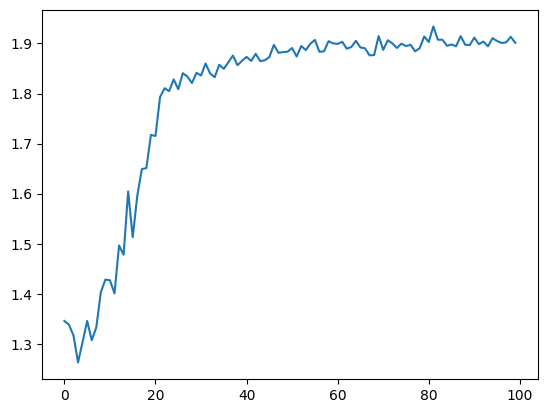

In [ ]:
plt.plot(test_epoch_losses)

### PFAM dataset download

In [24]:
import requests
import os
import gzip
from Bio import AlignIO
import subprocess
from joblib import Parallel, delayed

# Output directories


# InterPro API endpoint for PFAM entries
interpro_url = "https://www.ebi.ac.uk/interpro/api/entry/pfam/"

# def get_all_pfam_ids():
#     """Get all PFAM accessions listed in InterPro."""
#     pfam_ids = set()
#     url = interpro_url
#     while url:
#         print(f"Fetching: {url}")
#         response = requests.get(url, headers={"Accept": "application/json"})
#         if response.status_code != 200:
#             print(f"Failed to fetch: {url}")
#             break
#         data = response.json()
#         for entry in data["results"]:
#             if "metadata" in entry and "accession" in entry["metadata"]:
#                 pfam_ids.add(entry["metadata"]["accession"])
#         url = data.get("next")  # pagination
#     return sorted(pfam_ids)

def download_and_extract_seed_alignment(pfam_id, size = "seed"):
    """Download and unzip the seed alignment file."""
    url = f"https://www.ebi.ac.uk/interpro/wwwapi//entry/pfam/{pfam_id}/?annotation=alignment:{size}&download"
    gz_path = os.path.join(output_dir_sth, f"{pfam_id}_seed.sth.gz")
    sth_path = os.path.join(output_dir_sth, f"{pfam_id}_seed.sth")
    
    if os.path.exists(sth_path):
        print(f"Already downloaded and extracted: {pfam_id}")
        return sth_path
    
    r = requests.get(url, stream=True)
    if r.status_code == 200:
        with open(gz_path, "wb") as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
        print(f"Downloaded: {pfam_id}")

        # Unzip
        try:
            with gzip.open(gz_path, "rt") as f_in, open(sth_path, "w") as f_out:
                f_out.write(f_in.read())
            print(f"Extracted: {pfam_id}")
            os.remove(gz_path)  # Clean up gz file
            return sth_path
        except:
            print(f"Does not exist: {pfam_id}")
            os.remove(gz_path)  # Clean up gz file
            return None
    else:
        print(f"Not found or failed to download: {pfam_id}")
        return None

def convert_stockholm_to_fasta(sth_path, pfam_id, size = "seed", overwrite = True):
    """Convert Stockholm alignment to FASTA format."""
    fasta_path = os.path.join(output_dir_fasta, f"{pfam_id}_{size}.fasta")
    hmm_path = os.path.join(hmm_dir, f"{pfam_id}.hmm")

    if os.path.exists(fasta_path):
        if overwrite:
            subprocess.run(["rm",fasta_path])
        else:
            return 
    try:

        alignment = AlignIO.read(sth_path, "stockholm")
        AlignIO.write(alignment, fasta_path, "fasta")

        with open(f"{fasta_path}.temp1", "w") as outfile:
            subprocess.run(["seqkit","replace","-s","-p","-","-r","",fasta_path], stdout=outfile)

        subprocess.run(["rm",fasta_path])

        with open(fasta_path, "w") as outfile:
            subprocess.run(["hmmalign","--amino","--informat","FASTA",hmm_path,f"{fasta_path}.temp1"], stdout=outfile)

        subprocess.run(["rm",f"{fasta_path}.temp1"])

        seqs = read_stockholm_preserve_dots(fasta_path)
        Seq_tuples_to_fasta(seqs, fasta_path)

        print(f"Converted to FASTA: {pfam_id}")


    except Exception as e:
        print(f"Failed to convert {pfam_id}: {e}")

def read_stockholm_preserve_dots(filename):
    seen_seq_ids = {}
    records = []
    with open(filename) as fh:
        for line in fh:
            if line.startswith("#") or not line.strip():
                continue
            if line.startswith("//"):
                break
            parts = line.strip().split()
            if len(parts) == 2:
                seq_id, seq = parts

                if seq_id in list(seen_seq_ids.keys()):
                    seen_seq_ids[seq_id] += remove_insertions(seq)
                else:
                    seen_seq_ids[seq_id] = remove_insertions(seq)

                # records.append((seq_id, remove_insertions(seq)))

    records = list(seen_seq_ids.items())
    return records

def get_MSAs(pfam_id, size = "seed"):

    sth_path = download_and_extract_seed_alignment(pfam_id,size=size)

    if sth_path and size == "full":
        seqs = read_stockholm_preserve_dots(sth_path)

        fasta_path = os.path.join(output_dir_fasta, f"{pfam_id}_{size}.fasta")
        Seq_tuples_to_fasta(seqs, fasta_path)

    if sth_path and size == "seed":
        convert_stockholm_to_fasta(sth_path, pfam_id, size = size)

if __name__ == "__main__":
    # pfam_ids = get_all_pfam_ids()

    size= "full"

    output_dir_sth = f"./data/protein-families-msa-{size}/stockholm"
    output_dir_fasta = f"./data/protein-families-msa-{size}/"
    hmm_dir = f"./data/protein-families-hmms/"
    os.makedirs(output_dir_sth, exist_ok=True)
    os.makedirs(output_dir_fasta, exist_ok=True)

    pfam_ids = ["PF" + f"{x:.4f}".replace(".","") for x in list(np.arange(0.0001,2.5831,0.0001))]
    print(f"Total PFAM entries from InterPro: {len(pfam_ids)}")

    Parallel(n_jobs=10)(delayed(get_MSAs)(pfam_id, size) for pfam_id in pfam_ids)
    
    # for pfam_id in pfam_ids[:1]:
    #     sth_path = download_and_extract_seed_alignment(pfam_id,size=size)

    #     if sth_path and size == "full":
    #         seqs = read_stockholm_preserve_dots(sth_path)

    #         fasta_path = os.path.join(output_dir_fasta, f"{pfam_id}_{size}.fasta")
    #         Seq_tuples_to_fasta(seqs, fasta_path)

    #     if sth_path and size == "seed":
    #         convert_stockholm_to_fasta(sth_path, pfam_id, size = size)

Total PFAM entries from InterPro: 25830


Already downloaded and extracted: PF00005
Already downloaded and extracted: PF00003
Already downloaded and extracted: PF00002
Already downloaded and extracted: PF00007
Already downloaded and extracted: PF00001
Already downloaded and extracted: PF00004
Already downloaded and extracted: PF00006
Already downloaded and extracted: PF00009
Already downloaded and extracted: PF00008
Already downloaded and extracted: PF00010
Already downloaded and extracted: PF00011
Already downloaded and extracted: PF00012
Already downloaded and extracted: PF00013
Already downloaded and extracted: PF00014
Already downloaded and extracted: PF00015
Already downloaded and extracted: PF00016
Already downloaded and extracted: PF00017
Already downloaded and extracted: PF00018
Already downloaded and extracted: PF00019
Already downloaded and extracted: PF00020
Already downloaded and extracted: PF00021
Already downloaded and extracted: PF00022
Already downloaded and extracted: PF00023
Already downloaded and extracted: 

KeyboardInterrupt: 

In [ ]:
from joblib import Parallel, delayed
import requests
import os
import gzip
from Bio import AlignIO
import subprocess
from joblib import Parallel, delayed


def download_and_extract_hmm(pfam_id):
    """Download and unzip the seed alignment file."""
    url = f"https://www.ebi.ac.uk/interpro/wwwapi//entry/pfam/{pfam_id}?annotation=hmm"
    gz_path = os.path.join(output_dir, f"{pfam_id}.hmm.gz")
    hmm_path = os.path.join(output_dir, f"{pfam_id}.hmm")
    
    if os.path.exists(hmm_path):
        print(f"Already downloaded and extracted: {pfam_id}")
        return hmm_path
    
    r = requests.get(url, stream=True)
    if r.status_code == 200:
        with open(gz_path, "wb") as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
        print(f"Downloaded: {pfam_id}")

        # Unzip
        try:
            with gzip.open(gz_path, "rt") as f_in, open(hmm_path, "w") as f_out:
                f_out.write(f_in.read())
            print(f"Extracted: {pfam_id}")
            os.remove(gz_path)  # Clean up gz file
        except:
            print(f"Does not exist: {pfam_id}")
            os.remove(gz_path)  # Clean up gz file
    else:
        print(f"Not found or failed to download: {pfam_id}")
    
if __name__ == "__main__":

    output_dir = f"../Phylomodel/data/protein-families-hmms/"
    os.makedirs(output_dir, exist_ok=True)

    pfam_ids = ["PF" + f"{x:.4f}".replace(".","") for x in list(np.arange(0.0001,2.5831,0.0001))]
    print(f"Total PFAM entries from InterPro: {len(pfam_ids)}")

    Parallel(n_jobs=10)(delayed(download_and_extract_hmm)(pfam_id) for pfam_id in pfam_ids)
    
    # for pfam_id in pfam_ids:
    #     hmm_path = download_and_extract_hmm(pfam_id)   

In [20]:
import os 

families = []
seq_lens = []
seq_depths = []

for file in os.listdir("./data/protein-families-msa-seed/"):

    file_path = os.path.join("./data/protein-families-msa-seed/",file)
    seqs =  [(record.description, remove_insertions(str(record.seq))) for record in SeqIO.parse(file_path, "fasta")]

    seq_len = len(seqs[0][1])
    seq_depth = len(seqs)

    if seq_len <= 500 and seq_depth <= 500 and seq_depth >= 10 and seq_len >= 10:
        families.append(file.split("_")[0])
        seq_lens.append(seq_len)
        seq_depths.append(seq_depth)

In [21]:
len(families)

16301

In [22]:
import pickle as pkl

with open("./data/families_under_500_over_10.pkl","wb") as f:
    pkl.dump(families, f)

In [ ]:
with open("families_under_200.pkl","rb") as f:
    fams = pkl.load(f)

(0.0, 1000.0)

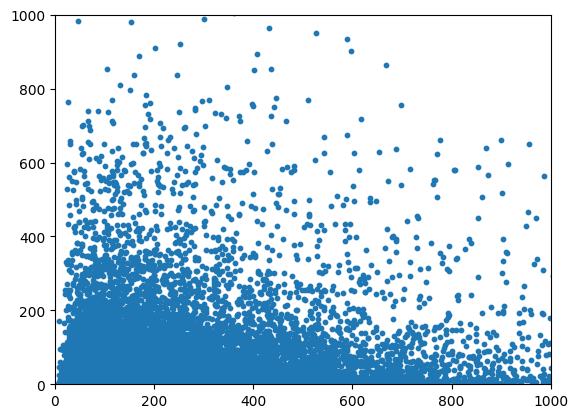

In [56]:
plt.scatter(seq_lens, seq_depths, s=10)
plt.xlim((0,1000))
plt.ylim((0,1000))

(array([4.655e+03, 7.555e+03, 4.691e+03, 2.707e+03, 1.646e+03, 1.137e+03,
        6.480e+02, 5.290e+02, 2.950e+02, 2.230e+02, 1.610e+02, 1.100e+02,
        8.800e+01, 6.500e+01, 5.300e+01, 3.800e+01, 2.100e+01, 2.600e+01,
        1.400e+01, 1.000e+01, 1.900e+01, 1.000e+01, 3.000e+00, 5.000e+00,
        4.000e+00, 6.000e+00, 3.000e+00, 4.000e+00, 1.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([   7.  ,   79.38,  151.76,  224.14,  296.52,  368.9 ,  441.28,
         513.66,  586.04,  658.42,  730.8 ,  803.18,  875.56,  947.94,
        1020.32, 1092.7 , 1165.08, 1237.46, 1309.84, 1382.22, 1454.6 ,
        1526.98, 1599.36, 1671.74, 1744.12, 1816.5 , 1888.88, 1961.26,
        2033.64, 2106.02, 2178.4 , 2250.78, 2323.16, 2395.54, 2467.92,
        2540.3 , 2612

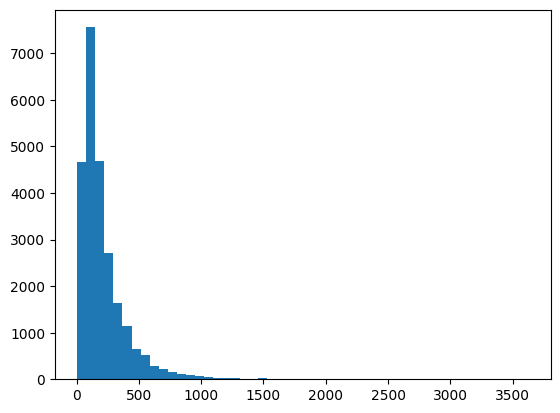

In [41]:
import matplotlib.pyplot as plt

plt.hist(seq_lens, bins=50)

### Dataset Preparation

In [3]:
import subprocess

def make_branch_lengths(tree):

    leaf_lengths_dict = {}
    internal_lengths_dict = {}
    internal_distances_from_root = {}
    child_parent_rel = {}


    for node in tree.traverse("preorder"):    
        if node.is_root():
            internal_distances_from_root[node.name] = 0
            internal_lengths_dict[node.name] = 0
            child_parent_rel[node.name] = -1
            continue
        else:
            branch_length = node.get_distance(node.up)
            
            if node.is_leaf():
                leaf_lengths_dict[node.name] = branch_length
            else:
                internal_lengths_dict[node.name] = branch_length
                internal_distances_from_root[node.name] = node.get_distance(tree)

            child_parent_rel[node.name] = node.up.name
            
    return leaf_lengths_dict, internal_lengths_dict, internal_distances_from_root, child_parent_rel


def prepare_branch_lengths_and_relationships(true_tree_path, nat_MSA_path):

    nat_sequences = [(record.description, remove_insertions(str(record.seq))) for record in SeqIO.parse(nat_MSA_path, "fasta")]
    true_tree = Phylo.read(true_tree_path, format="newick")

    nat_sequences = reorder_seqs(true_tree.clade, dict(nat_sequences))
    nat_seqs_order = [seq[0] for seq in nat_sequences]

    _, true_tree, node_taxa_mapping, taxa_node_mapping = newick_to_graph(true_tree_path)
    leaf_lengths_dict, internal_lengths_dict, internal_distances_from_root, child_parent_rel  = make_branch_lengths(true_tree)

    leaf_branch_lengths = [leaf_lengths_dict[taxa_node_mapping[seq_name]] for seq_name in nat_seqs_order]

    sorted_internal_distances_from_root_indices = np.argsort(list(internal_distances_from_root.values()))
    sorted_internal_nodes= np.array(list(internal_distances_from_root.keys()))[sorted_internal_distances_from_root_indices]

    internal_branch_lengths = [internal_lengths_dict[node] for node in sorted_internal_nodes]

    all_branch_lengths =  internal_branch_lengths + leaf_branch_lengths
    all_branch_lengths = torch.tensor(all_branch_lengths)

    leaf_node_parents = [child_parent_rel[taxa_node_mapping[taxa]] for taxa in nat_seqs_order]
    int_node_parents = [child_parent_rel[node] for node in sorted_internal_nodes]

    all_parents = int_node_parents + leaf_node_parents
    parents_mapping = {node:ind for ind, node in enumerate(sorted_internal_nodes)}
    parents_mapping[-1] = -2

    all_parents_mapped = torch.tensor([int(parents_mapping[node]) for node in all_parents])

    return all_branch_lengths, all_parents_mapped, sorted_internal_nodes

def prepare_initial_int_node_embeddings(MSA_file_path, true_tree_path, Large_D = 1000, leaf_embeddings = None):

    # true_tree = Phylo.read(true_tree_path, format="newick")

    # sequences = [(record.description, remove_insertions(str(record.seq))) for record in SeqIO.parse(MSA_file_path, "fasta")]
    # sequences = reorder_seqs(true_tree.clade, dict(sequences))
        
    # _,_,batch_tokens = batch_converter([sequences])
    # batch_tokens = batch_tokens.to(device)

    # with torch.no_grad():
    #     leaf_embeddings = model(batch_tokens, need_head_weights = False, return_contacts = False, repr_layers = [12])["representations"][12][0]
    #     leaf_embeddings = leaf_embeddings.mean(dim=1).cpu()
    #     R, C = leaf_embeddings.shape
    #     padding_tensor = torch.zeros((R, Large_D - C))
    #     leaf_embeddings = torch.concat((leaf_embeddings, padding_tensor), dim=1)

    # del(batch_tokens)
    # torch.cuda.empty_cache()

    temp_tree_file = f"{MSA_file_path}-temp.newick"

    subprocess.run(["rapidnj",MSA_file_path,"-i","fa","-x",temp_tree_file])

    _, init_tree, _, _ = newick_to_graph(temp_tree_file) 
 
    subprocess.run(['rm', temp_tree_file])
    # subprocess.run(['rm', temp_matrix_file])

    internal_node_embeddings, edges, leaf_indices = node_embedding(init_tree, rooted=True, leaf_embeddings=leaf_embeddings)
    _, _, init_distances_from_root, _  = make_branch_lengths(init_tree)

    sorted_init_distances_from_root_indices = np.argsort(list(init_distances_from_root.values()))
    
    sorted_init_nodes = np.array(list(init_distances_from_root.keys()))[sorted_init_distances_from_root_indices]

    # if task == "bl_pred":
    #     sorted_init_nodes = sorted_init_nodes[1:]
    
    sorted_internal_node_embeddings = internal_node_embeddings[sorted_init_nodes]
    R, C = sorted_internal_node_embeddings.shape
    
    padding_tensor = torch.zeros((R, Large_D - C))
    sorted_internal_node_embeddings = torch.concat((sorted_internal_node_embeddings, padding_tensor), dim=1)

    # all_embeddings = torch.concat((sorted_internal_node_embeddings, leaf_embeddings), dim = 0)

    return sorted_internal_node_embeddings

def prepare_initial_leaf_embeddings(families, Large_D = 1000, batch_size = 10):

    torch.cuda.empty_cache()
    
    all_embeddings = []

    msa_folder = "./data/protein-families-msa-seed/"
    tree_folder ="./data/seed-trees/"
    # Process in batches
    for batch_start in tqdm(range(0, len(families), batch_size)):

        current_batch = range(batch_start, batch_start + batch_size)

        true_trees = [Phylo.read(os.path.join(tree_folder, f"{families[i]}_seed.newick"), format="newick") for i in current_batch]
        batch_paths = [os.path.join(msa_folder, f"{families[i]}_seed.fasta") for i in current_batch]

        # Load MSAs
        batch_data = [read_msa(p) for p in batch_paths]
        batch_data = [reorder_seqs(true_trees[i].clade, dict(batch_data[i])) for i in range(len(batch_data))]

        # Store sizes for unbatching
        msa_depths = [len(msa) for msa in batch_data]
        msa_lengths = [len(msa[0][1]) for msa in batch_data]

        # Convert to tokens
        _, _, batch_tokens = batch_converter(batch_data)  # shape: (B, N_max, L_max)
        batch_tokens = batch_tokens.to(device)

        with torch.no_grad():
            batch_embeddings = model(batch_tokens, need_head_weights = False, return_contacts = False, repr_layers = [12])["representations"][12]
            batch_embeddings = batch_embeddings.mean(dim=2)
            B, R, H = batch_embeddings.shape
            padding_tensor = torch.zeros((B,R, Large_D - H)).to(device)
            batch_embeddings = torch.concat((batch_embeddings, padding_tensor), dim=2)

            del padding_tensor

            for i, (depth, length, path) in enumerate(zip(msa_depths, msa_lengths, batch_paths)):
                
                leaf_emb = batch_embeddings[i, :depth, :].cpu()
                all_embeddings.append(leaf_emb)

            del batch_tokens, batch_embeddings
            torch.cuda.empty_cache()


    return all_embeddings

In [4]:
import os
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scripts.select_gpu import get_free_gpu
from sklearn.metrics import r2_score
import pickle as pkl

torch.cuda.empty_cache()

gpu = str(get_free_gpu())
device = f"cuda:{gpu}" if torch.cuda.is_available() else "cpu"
model, alphabet = esm.pretrained.esm_msa1b_t12_100M_UR50S()
model = model.to(device)
batch_converter = alphabet.get_batch_converter()
model.eval()

MSATransformer(
  (embed_tokens): Embedding(33, 768, padding_idx=1)
  (dropout_module): Dropout(p=0.1, inplace=False)
  (layers): ModuleList(
    (0-11): 12 x AxialTransformerLayer(
      (row_self_attention): NormalizedResidualBlock(
        (layer): RowSelfAttention(
          (k_proj): Linear(in_features=768, out_features=768, bias=True)
          (v_proj): Linear(in_features=768, out_features=768, bias=True)
          (q_proj): Linear(in_features=768, out_features=768, bias=True)
          (out_proj): Linear(in_features=768, out_features=768, bias=True)
          (dropout_module): Dropout(p=0.1, inplace=False)
        )
        (dropout_module): Dropout(p=0.1, inplace=False)
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      )
      (column_self_attention): NormalizedResidualBlock(
        (layer): ColumnSelfAttention(
          (k_proj): Linear(in_features=768, out_features=768, bias=True)
          (v_proj): Linear(in_features=768, out_features=768,

In [ ]:
def make_datasets(family, leaf_embeddings = None, Large_D = 1000):
    
    true_tree_path = f"./data/seed-trees/{family}_seed.newick"
    nat_MSA_path = f"./data/protein-families-msa-seed/{family}_seed.fasta"
    
    all_branch_lengths, mapped_parents, sorted_internal_nodes = prepare_branch_lengths_and_relationships(true_tree_path, nat_MSA_path)

    all_embeddings = prepare_initial_int_node_embeddings(nat_MSA_path, true_tree_path, Large_D = Large_D, leaf_embeddings = leaf_embeddings)

    return all_embeddings, all_branch_lengths, mapped_parents

In [ ]:
import pickle as pkl
from joblib import Parallel, delayed
import torch
from tqdm import tqdm

# torch.set_num_threads(1) 

np.random.seed(42)

Large_D = 768

X_train = []
X_test = []

y_train_bl = []
y_test_bl = []

y_train_pc = []
y_test_pc = []

with open("./data/families_under_500_over_10.pkl","rb") as f:

    all_families = pkl.load(f)

train_split = 0.9
train_size = int(np.ceil(train_split * len(all_families)))

train_families_ind = np.random.choice(range(len(all_families)), train_size, replace = False)
train_families = [all_families[ind] for ind in train_families_ind]

test_families_ind = list(set(range(len(all_families))) - set(train_families_ind))
test_families = [all_families[ind] for ind in test_families_ind]

train_leaf_embeds = prepare_initial_leaf_embeddings(train_families, Large_D = Large_D, batch_size = 1)
test_leaf_embeds = prepare_initial_leaf_embeddings(test_families, Large_D = Large_D, batch_size = 1)

# train_res = Parallel(n_jobs = 30, backend="multiprocessing")(delayed(make_datasets)(family) for family in train_families)
# test_res = Parallel(n_jobs = 30, backend="multiprocessing")(delayed(make_datasets)(family) for family in test_families)

train_res = list(
    tqdm(
        Parallel(return_as="generator", n_jobs=30)(
            delayed(make_datasets)(family, train_leaf_embeds[i], Large_D) for i,family in enumerate(train_families)
        ),
        total=len(train_families),
    )
)

test_res = list(
    tqdm(
        Parallel(return_as="generator", n_jobs=30)(
            delayed(make_datasets)(family, test_leaf_embeds[i], Large_D) for i, family in enumerate(test_families)
        ),
        total=len(test_families),
    )
)





# for i, family in enumerate(train_families):

#     true_tree_path = f"./data/seed-trees/{family}_seed.newick"
#     nat_MSA_path = f"./data/protein-families-msa-seed/{family}_seed.fasta"

#     if (i % 100) == 0:
#         print(i)
    
#     all_branch_lengths, mapped_parents, sorted_internal_nodes = prepare_branch_lengths_and_relationships(true_tree_path, nat_MSA_path)

#     all_embeddings = prepare_initial_node_embeddings(nat_MSA_path, true_tree_path, Large_D = Large_D)

#     X_train.append(all_embeddings)
#     y_train_bl.append(all_branch_lengths)
#     y_train_pc.append(mapped_parents)


# for family in test_families:

#     true_tree_path = f"./data/seed-trees/{family}_seed.newick"
#     nat_MSA_path = f"./data/protein-families-msa-seed/{family}_seed.fasta"
    
#     all_branch_lengths, mapped_parents, sorted_internal_nodes = prepare_branch_lengths_and_relationships(true_tree_path, nat_MSA_path)

#     all_embeddings = prepare_initial_node_embeddings(nat_MSA_path, true_tree_path, Large_D = Large_D)

#     X_test.append(all_embeddings)
#     y_test_bl.append(all_branch_lengths)
#     y_test_pc.append(mapped_parents)

                                  

# for family in families:

#     true_tree_path = f"./data/seed-trees/{family}_seed.newick"
#     nat_MSA_path = f"./data/protein-families-msa-seed/{family}_seed.fasta"
#     MSA_folder = f"./data/msa-seed-simulations/MSA-1b/{family}/init-seq-0/logits-proposal/static-context/10/"
    
#     all_branch_lengths, mapped_parents, sorted_internal_nodes = prepare_branch_lengths_and_relationships(true_tree_path, nat_MSA_path)

#     for file in os.listdir(MSA_folder)[-70:]:

#         file_path = os.path.join(MSA_folder, file)
        
#         all_embeddings = prepare_initial_node_embeddings(file_path, Large_D = Large_D)

#         X_train.append(all_embeddings)
#         y_train_bl.append(all_branch_lengths)
#         y_train_pc.append(mapped_parents)

#     for file in os.listdir(MSA_folder)[:-70]:

#         file_path = os.path.join(MSA_folder, file)

#         all_embeddings = prepare_initial_node_embeddings(file_path, Large_D = Large_D)

#         X_test.append(all_embeddings)
#         y_test_bl.append(all_branch_lengths)
#         y_test_pc.append(mapped_parents)

    

100%|██████████| 1/1 [00:00<00:00,  6.27it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:02<00:00,  2.16s/it]
0it [00:00, ?it/s]


In [44]:
X_train = [torch.concat((train_res[i][0], train_leaf_embeds[i]), dim=0) for i in range(len(train_res))]
y_train_bl = [item[1] for item in train_res]
y_train_pc = [item[2] for item in train_res]

X_test = [torch.concat((test_res[i][0], test_leaf_embeds[i]), dim=0) for i in range(len(test_res))]
y_test_bl = [item[1] for item in test_res]
y_test_pc = [item[2] for item in test_res]

In [14]:
y_train_pc[0][:54]

tensor([-2,  0,  0,  2,  1,  4,  2,  3,  3,  6,  9,  8,  5,  5, 13, 14,  7,  7,
        12,  8,  9, 15, 13, 21, 20, 11, 24, 22, 20, 22, 10, 26, 28, 27, 29, 23,
        15, 28, 23, 24, 27, 34,  6, 38, 35, 43, 37, 36, 34, 45, 39, 48, 49, 52])

In [16]:
with open("train_test_sets.pkl","wb") as f:
    pkl.dump([X_train, X_test, y_train_bl, y_test_bl, y_train_pc, y_test_pc], f)

In [49]:
with open("./scripts/train_test_sets_MSA_transf_dirichlet.pkl","rb") as f:
   data = pkl.load(f)

In [50]:
X_train = data[0]
X_test = data[1]
y_train_bl = data[2]
y_test_bl = data[3]
y_train_pc = data[4]
y_test_pc = data[5]

### Parent Node Predictor

In [12]:
class TransformerBlock(nn.Module):

    def __init__(self, hidden_dim, transformer_embed_dim, n_heads):

        super().__init__()

        self.hidden_dim = hidden_dim
        self.embed_dim = transformer_embed_dim
        self.n_heads = n_heads

        self.layer_norm = nn.LayerNorm(self.embed_dim)
        self.projections = nn.ModuleList([nn.Linear(self.embed_dim, self.embed_dim) for _  in range(3)])
        self.mha = nn.MultiheadAttention(self.embed_dim, num_heads=self.n_heads)
        self.fc_post_attn = nn.Linear(self.embed_dim, self.embed_dim)
        self.activation = nn.GELU()
        self.batch_norm = nn.BatchNorm1d(self.hidden_dim)

    def forward(self,x, attn_mask = None):

        residual = x.clone()
        x = self.layer_norm(x)
        q, k, v = tuple(self.projections[i](x) for i in range(3))
        x, _ = self.mha(q,k,v, need_weights = False, attn_mask = attn_mask)
        x = x + residual
        residual = x.clone()
        x = self.layer_norm(x)
        x = self.activation(self.fc_post_attn(x))
        x += residual

        return(x)


class ParentPredictor(nn.Module):

    def __init__(self, input_dim, hidden_dim, transformer_embed_dim, n_heads, n_layers, output_dim):

        super().__init__() 

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.embed_dim = transformer_embed_dim
        self.n_heads = n_heads
        self.n_layers = n_layers
        self.output_dim = output_dim
        self.activation = nn.GELU()

        self.fc_init = nn.Linear(self.input_dim, self. hidden_dim)
        self.transformer_layers = nn.ModuleList([TransformerBlock(self.hidden_dim, self. embed_dim, self.n_heads) for _ in range(self.n_layers)])
        self.output_layer = nn.Linear(self.hidden_dim, self.output_dim)
        self.fc_pre_attn = nn.Linear(self.hidden_dim, self. embed_dim)
        self.fc_post_attn = nn.Linear(self.embed_dim, self. hidden_dim)

    def forward(self, x, attn_mask = None):

        x = self.activation(self.fc_init(x))
        x = self.activation(self.fc_pre_attn(x))

        for layer in self.transformer_layers:
            x = layer(x, attn_mask = attn_mask)

        x = self.activation(self.fc_post_attn(x))
        x = self.output_layer(x)

        return x





In [10]:
class TreeDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data[0])

    def __getitem__(self, idx):
        X, y = self.data[0][idx], self.data[1][idx]
        return X, y

def collate_tensors(
sequences: Sequence[TensorLike], constant_value=0, dtype=None
) -> TensorLike:
    
    batch_size = len(sequences)

    X_batch, y_batch = zip(*sequences)
    X_batch, y_batch = list(X_batch), list(y_batch)
    
    shape_X = [batch_size] + np.max([mat.shape for mat in X_batch], 0).tolist()
    shape_y = [batch_size] + [shape_X[1]]

    if dtype is None:
        dtype = X_batch[0].dtype

    if isinstance(X_batch[0], np.ndarray):
        X_array = np.full(shape_X, constant_value, dtype=dtype)
    elif isinstance(X_batch[0], torch.Tensor):
        X_array = torch.full(shape_X, constant_value, dtype=dtype)

    if isinstance(y_batch[0], np.ndarray):
        y_array = np.full(shape_y, -1, dtype=y_batch[0][0].dtype)
    elif isinstance(y_batch[0], torch.Tensor):
        y_array = torch.full(shape_y, -1, dtype=y_batch[0][0].dtype)
        
    for arr, mat in zip(X_array, X_batch):
        arrslice = tuple(slice(dim) for dim in mat.shape)
        arr[arrslice] = mat

    for arr, mat in zip(y_array, y_batch):
        arrslice = tuple(slice(dim) for dim in mat.shape)
        arr[arrslice] = mat


    return X_array, y_array

In [14]:
train_dataset = TreeDataset((X_train, y_train_pc))
test_dataset = TreeDataset((X_test, y_test_pc))

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                        batch_size=5, 
                                        collate_fn=collate_tensors,
                                        shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                        batch_size=1, 
                                        collate_fn=collate_tensors,
                                        shuffle=False)

lr = 0.001
lamb = 0.1
num_epochs = 50
Large_D = 1000

model = ParentPredictor(Large_D, 64, 64, 4, 2, 1000).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1)
criterion = nn.CrossEntropyLoss()
criterion_sum = nn.CrossEntropyLoss(reduction="sum")

n_total_steps = len(train_loader)

train_epoch_losses = []
test_epoch_losses = []

for epoch in range(num_epochs):

    train_epoch_outputs = []
    train_labels = []

    model.train()

    for i, (data, labels) in enumerate(train_loader):

        n_train_nodes = 0

        total_loss = torch.tensor(0, dtype=torch.float32).to(device)
        ce_loss = torch.tensor(0, dtype=torch.float32).to(device)
        regularizer_loss = torch.tensor(0, dtype=torch.float32).to(device)

        n_int_nodes_list = []

        for j in range(len(labels)):

            total_nodes = (labels[j] != -1).sum()
            n_int_nodes = int((total_nodes + 1)/2 - 1)

            n_int_nodes_list.append(n_int_nodes) 

        n_int_nodes_vector = [torch.tensor([n_nodes] * len(labels[0])) for n_nodes in n_int_nodes_list]
        n_int_nodes_vector = torch.concat(n_int_nodes_vector)

        n_int_nodes_list = torch.tensor(n_int_nodes_list)

        for n_nodes in n_int_nodes_list.unique():

            data_j = data[n_int_nodes_list == n_nodes]
            labels_j = labels[n_int_nodes_list == n_nodes]

            msa_index_vector_j = [torch.tensor([ind] * len(labels_j[0])) for ind in range(len(data_j))]
            msa_index_vector_j = torch.concat(msa_index_vector_j)

            seq_mask = (labels_j != -1)

            data_j = data_j[seq_mask, :].to(device)
            labels_j = labels_j[seq_mask].to(device)
            msa_index_vector_j = msa_index_vector_j[seq_mask.flatten()].to(device)

            attn_mask = (msa_index_vector_j.unsqueeze(0) == msa_index_vector_j.unsqueeze(1)).float() 
            attn_mask = (1 - attn_mask) * -1e9

            outputs = model(data_j, attn_mask = attn_mask).squeeze(-1)[...,:n_nodes]

            root_mask = labels_j != -2

            cur_ce_loss = criterion_sum(outputs[root_mask, :], labels_j[root_mask])
            cur_regularizer_loss = lamb * torch.linalg.vector_norm(torch.softmax(outputs, dim = 1).sum(dim = 0) - 2).type_as(cur_ce_loss)

            total_loss += cur_ce_loss # + cur_regularizer_loss
            ce_loss += cur_ce_loss
            # regularizer_loss = cur_regularizer_loss
            n_train_nodes += len(labels_j[root_mask])
        
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        if (i+1) % 1 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], mean CE Loss: {(ce_loss/n_train_nodes).item():.4f}')

    scheduler.step()

    model.eval()

    with torch.no_grad():

        train_epoch_loss = torch.tensor(0, dtype=torch.float32).to(device)
        n_train_nodes = 0
       
        for i, (data, labels) in enumerate(train_loader):
            
            n_int_nodes_list = []

            for j in range(len(labels)):

                total_nodes = (labels[j] != -1).sum()
                n_int_nodes = int((total_nodes + 1)/2 - 1)

                n_int_nodes_list.append(n_int_nodes) 

            n_int_nodes_vector = [torch.tensor([n_nodes] * len(labels[0])) for n_nodes in n_int_nodes_list]
            n_int_nodes_vector = torch.concat(n_int_nodes_vector)

            n_int_nodes_list = torch.tensor(n_int_nodes_list)

            for n_nodes in n_int_nodes_list.unique():

                data_j = data[n_int_nodes_list == n_nodes]
                labels_j = labels[n_int_nodes_list == n_nodes]

                cur_n_train = len(data_j)

                msa_index_vector_j = [torch.tensor([ind] * len(labels_j[0])) for ind in range(len(data_j))]
                msa_index_vector_j = torch.concat(msa_index_vector_j)

                seq_mask = (labels_j != -1)

                data_j = data_j[seq_mask, :].to(device)
                labels_j = labels_j[seq_mask].to(device)
                msa_index_vector_j = msa_index_vector_j[seq_mask.flatten()].to(device)

                attn_mask = (msa_index_vector_j.unsqueeze(0) == msa_index_vector_j.unsqueeze(1)).float() 
                attn_mask = (1 - attn_mask) * -1e9

                outputs = model(data_j, attn_mask = attn_mask).squeeze(-1)[...,:n_nodes]

                root_mask = labels_j != -2

                train_epoch_loss += criterion_sum(outputs[root_mask, :], labels_j[root_mask])
                n_train_nodes += len(labels_j[root_mask])

        train_epoch_losses.append((train_epoch_loss/n_train_nodes).item())

    with torch.no_grad():

        test_epoch_loss = torch.tensor(0, dtype=torch.float32).to(device)
        n_test_nodes = 0

        for i, (data, labels) in enumerate(test_loader):

            n_int_nodes_list = []

            for j in range(len(labels)):

                total_nodes = (labels[j] != -1).sum()
                n_int_nodes = int((total_nodes + 1)/2 - 1)

                n_int_nodes_list.append(n_int_nodes) 

            n_int_nodes_vector = [torch.tensor([n_nodes] * len(labels[0])) for n_nodes in n_int_nodes_list]
            n_int_nodes_vector = torch.concat(n_int_nodes_vector)

            n_int_nodes_list = torch.tensor(n_int_nodes_list)

            for n_nodes in n_int_nodes_list.unique():

                data_j = data[n_int_nodes_list == n_nodes]
                labels_j = labels[n_int_nodes_list == n_nodes]

                cur_n_test = len(data_j)

                msa_index_vector_j = [torch.tensor([ind] * len(labels_j[0])) for ind in range(len(data_j))]
                msa_index_vector_j = torch.concat(msa_index_vector_j)

                seq_mask = (labels_j != -1)

                data_j = data_j[seq_mask, :].to(device)
                labels_j = labels_j[seq_mask].to(device)
                msa_index_vector_j = msa_index_vector_j[seq_mask.flatten()].to(device)

                attn_mask = (msa_index_vector_j.unsqueeze(0) == msa_index_vector_j.unsqueeze(1)).float() 
                attn_mask = (1 - attn_mask) * -1e9

                outputs = model(data_j, attn_mask = attn_mask).squeeze(-1)[...,:n_nodes]

                root_mask = labels_j != -2

                test_epoch_loss += criterion_sum(outputs[root_mask, :], labels_j[root_mask])
                n_test_nodes += len(labels_j[root_mask])

        test_epoch_losses.append((test_epoch_loss/n_test_nodes).item())

Epoch [1/50], Step [1/2749], mean CE Loss: 4.6370
Epoch [1/50], Step [2/2749], mean CE Loss: 3.9705
Epoch [1/50], Step [3/2749], mean CE Loss: 4.0902
Epoch [1/50], Step [4/2749], mean CE Loss: 3.5048
Epoch [1/50], Step [5/2749], mean CE Loss: 4.3350
Epoch [1/50], Step [6/2749], mean CE Loss: 5.4647
Epoch [1/50], Step [7/2749], mean CE Loss: 3.4047
Epoch [1/50], Step [8/2749], mean CE Loss: 4.8416
Epoch [1/50], Step [9/2749], mean CE Loss: 4.3459
Epoch [1/50], Step [10/2749], mean CE Loss: 4.2175
Epoch [1/50], Step [11/2749], mean CE Loss: 3.6462
Epoch [1/50], Step [12/2749], mean CE Loss: 3.8264
Epoch [1/50], Step [13/2749], mean CE Loss: 3.7823
Epoch [1/50], Step [14/2749], mean CE Loss: 3.9078
Epoch [1/50], Step [15/2749], mean CE Loss: 4.0853
Epoch [1/50], Step [16/2749], mean CE Loss: 5.2860
Epoch [1/50], Step [17/2749], mean CE Loss: 4.3880
Epoch [1/50], Step [18/2749], mean CE Loss: 4.2926
Epoch [1/50], Step [19/2749], mean CE Loss: 4.7524
Epoch [1/50], Step [20/2749], mean CE Lo

In [15]:
torch.save(model.state_dict(), "model_1000_64_64_4_2_1000_50epochs_0.001lr.pt")

In [35]:
pfam_metadata = pd.read_csv("./data/pfam-metadata/pfam_metadata.tsv", delimiter = "\t")
pfam_metadata["seed_sizes"].__len__()

14

In [16]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

204456

In [6]:
import pickle as pkl

with open("./losses/train_losses_100epochs_0.0001lr_5batch_large.pkl","rb") as f:
    train_epoch_losses = pkl.load(f)

with open("./losses/test_losses_100epochs_0.0001lr_5batch_large.pkl","rb") as f:
    test_epoch_losses = pkl.load(f)

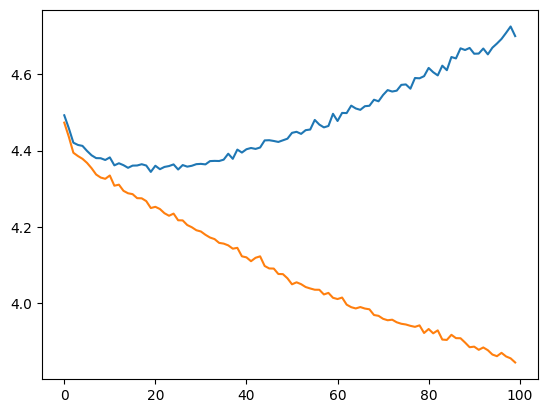

In [7]:
import matplotlib.pyplot as plt

plt.plot(test_epoch_losses)
plt.plot(train_epoch_losses)
plt.savefig("./losses/losses_100epochs_0.0001lr_5batch_large.png")

In [109]:
total_nodes

tensor(413)

### Branch Length Predictor

In [34]:
class TransformerBlock(nn.Module):

    def __init__(self, hidden_dim, transformer_embed_dim, n_heads):

        super().__init__()

        self.hidden_dim = hidden_dim
        self.embed_dim = transformer_embed_dim
        self.n_heads = n_heads

        self.layer_norm = nn.LayerNorm(self.embed_dim)
        self.projections = nn.ModuleList([nn.Linear(self.hidden_dim, self.embed_dim) for _  in range(3)])
        self.mha = nn.MultiheadAttention(self.embed_dim, num_heads=self.n_heads)
        self.fc_post_attn = nn.Linear(self.embed_dim, self.embed_dim)
        self.activation = nn.GELU()
        self.batch_norm = nn.BatchNorm1d(self.hidden_dim)

    def forward(self,x, attn_mask = None):

        residual = x.clone()
        x = self.layer_norm(x)
        q, k, v = tuple(self.projections[i](x) for i in range(3))
        x, _ = self.mha(q,k,v, need_weights = False, attn_mask = attn_mask)
        x = x + residual
        residual = x.clone()
        x = self.layer_norm(x)
        x = self.activation(self.fc_post_attn(x))
        x += residual

        return(x)


class BranchLengthPredictor(nn.Module):

    def __init__(self, input_dim, hidden_dim, transformer_embed_dim, n_heads, n_layers):

        super().__init__() 

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.embed_dim = transformer_embed_dim
        self.n_heads = n_heads
        self.n_layers = n_layers
        self.activation = nn.GELU()

        self.fc_init = nn.Linear(self.input_dim, self. hidden_dim)
        self.transformer_layers = nn.ModuleList([TransformerBlock(self.embed_dim, self. embed_dim, self.n_heads) for _ in range(self.n_layers)])
        self.output_layer = nn.Linear(self.hidden_dim, 1)
        self.fc_pre_attn = nn.Linear(self.hidden_dim, self. embed_dim)
        self.fc_post_attn = nn.Linear(self.embed_dim, self. hidden_dim)

    def forward(self, x, attn_mask = None):

        x = self.activation(self.fc_init(x))
        x = self.activation(self.fc_pre_attn(x))

        for layer in self.transformer_layers:
            x = layer(x, attn_mask = attn_mask)

        x = self.activation(self.fc_post_attn(x))
        x = self.output_layer(x)

        return x

In [ ]:
train_dataset = TreeDataset((X_train, y_train_bl))
test_dataset = TreeDataset((X_test, y_test_bl))

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                        batch_size=10, 
                                        collate_fn=collate_tensors,
                                        shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                        batch_size=1, 
                                        collate_fn=collate_tensors,
                                        shuffle=False)

lr = 0.001
lamb = 0.1
num_epochs = 1000

model = BranchLengthPredictor(Large_D, 32, 256, 4, 2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
criterion = nn.L1Loss()
criterion_sum = nn.L1Loss(reduction="sum")

n_total_steps = len(train_loader)

train_epoch_losses = []
test_epoch_losses = []

for epoch in range(num_epochs):

    train_epoch_outputs = []
    train_labels = []

    model.train()

    for i, (data, labels) in enumerate(train_loader):

        total_loss = torch.tensor(0, dtype=torch.float32).to(device)

        msa_index_vector = [torch.tensor([ind] * len(labels[0])) for ind in range(len(data))]
        msa_index_vector = torch.concat(msa_index_vector)
 
        seq_mask = (labels != -1) 

        data = data[seq_mask, :].to(device)
        labels = labels[seq_mask].to(device)
        msa_index_vector = msa_index_vector[seq_mask.flatten()].to(device)

        attn_mask = (msa_index_vector.unsqueeze(0) == msa_index_vector.unsqueeze(1)).float() 
        attn_mask = (1 - attn_mask) * -1e9

        outputs = model(data, attn_mask = attn_mask).squeeze(-1)
        
        labels_mask = (labels != 0)
        total_loss = criterion(outputs[labels_mask], labels[labels_mask])

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        if (i+1) % 1 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], mean MSE Loss: {(total_loss).item():.4f}')

    scheduler.step()

    model.eval()

    with torch.no_grad():

        train_epoch_loss = torch.tensor(0, dtype=torch.float32).to(device)
        n_train_nodes = 0
       
        for i, (data, labels) in enumerate(train_loader):
            
            cur_n_train = len(labels)

            msa_index_vector = [torch.tensor([ind] * len(labels[0])) for ind in range(len(data))]
            msa_index_vector = torch.concat(msa_index_vector)
    
            seq_mask = (labels != -1) 

            data = data[seq_mask, :].to(device)
            labels = labels[seq_mask].to(device)
            msa_index_vector = msa_index_vector[seq_mask.flatten()].to(device)

            attn_mask = (msa_index_vector.unsqueeze(0) == msa_index_vector.unsqueeze(1)).float() 
            attn_mask = (1 - attn_mask) * -1e9

            outputs = model(data, attn_mask = attn_mask).squeeze(-1)

            labels_mask = (labels != 0)
            train_epoch_loss += criterion_sum(outputs[labels_mask], labels[labels_mask])
            n_train_nodes += len(labels[labels_mask])

        train_epoch_losses.append((train_epoch_loss/n_train_nodes).item())

    with torch.no_grad():

        test_epoch_loss = torch.tensor(0, dtype=torch.float32).to(device)
        n_test_nodes = 0

        for i, (data, labels) in enumerate(test_loader):
            
            cur_n_test = len(labels)

            msa_index_vector = [torch.tensor([ind] * len(labels[0])) for ind in range(len(data))]
            msa_index_vector = torch.concat(msa_index_vector)
    
            seq_mask = (labels != -1) 

            data = data[seq_mask, :].to(device)
            labels = labels[seq_mask].to(device)
            msa_index_vector = msa_index_vector[seq_mask.flatten()].to(device)

            attn_mask = (msa_index_vector.unsqueeze(0) == msa_index_vector.unsqueeze(1)).float() 
            attn_mask = (1 - attn_mask) * -1e9

            outputs = model(data, attn_mask = attn_mask).squeeze(-1)

            labels_mask = (labels != 0)
            test_epoch_loss += criterion_sum(outputs[labels_mask], labels[labels_mask])
            n_test_nodes += len(labels[labels_mask])


        test_epoch_losses.append((test_epoch_loss/n_test_nodes).item())

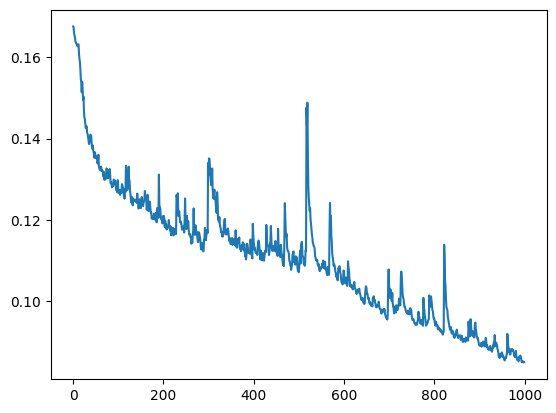

In [43]:
plt.plot(train_epoch_losses)

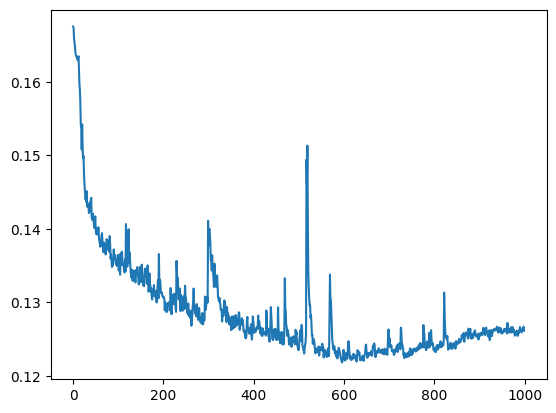

In [44]:
plt.plot(test_epoch_losses)

In [1]:
y_train_bl[0][1:].max()

NameError: name 'y_train_bl' is not defined